### Importation des données

In [ ]:
import pickle
# Later, you can load it from the file without recalculating
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

### Division des données sous forme des batches

In [ ]:
import random
import tensorflow as tf
batch_size = 32
batches = []

random.shuffle(data)  # to shuffle the list in-place

# Assuming train_data is a list of tuples (voxel_grid_tensor, class_label)
for i in range(0, len(data), batch_size):
    batch = data[i:i + batch_size]

    # Separate voxel grids and class labels
    voxel_grids = [item[0] for item in batch]
    class_labels = [item[1] for item in batch]

    # Append the batch as a tuple (list of tensors, list of class labels)
    batches.append((tf.stack(voxel_grids, axis=0), class_labels))

### Couches de convolution

In [ ]:
import tensorflow as tf

class ConvLayer(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(ConvLayer, self).__init__(**kwargs)
        # Batch Normalization after second conv layer
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.dropout1 = tf.keras.layers.Dropout(rate=0.1)
        self.dropout2 = tf.keras.layers.Dropout(rate=0.1)
        self.conv_layer1 = tf.keras.layers.Conv3D(
        filters=32,              # Apply 32 filters (feature maps).
        kernel_size=(3, 3, 3),   # Use a 3x3x3 convolution kernel.
        strides=(1, 1, 1),       # Stride of 1 in each direction (no downsampling).
        padding='same',          # Use 'same' padding to preserve input dimensions.
        activation='relu',
        use_bias=True        # Use ReLU activation function.
    )
        self.conv_layer2= tf.keras.layers.Conv3D(
        filters=64,              # Apply 64 filters (feature maps).
        kernel_size=(3, 3, 3),   # Use a 3x3x3 convolution kernel.
        strides=(2, 2, 2),       # Stride of 2 in each direction (downsampling by 2x).
        padding='same',          # Use 'same' padding to preserve input dimensions.
        activation='relu'        # Use ReLU activation function.
    ) # Bias is included by default in tf.keras.layers.Conv2D


    def call(self, inputs):
        x = self.conv_layer1(inputs)
        x = self.batch_norm1(x)
        x = tf.nn.relu(x)
        x = self.dropout1(x)

        x = self.conv_layer2(x)
        x = self.batch_norm2(x)
        x = tf.nn.relu(x)
        x = self.dropout2(x)
        return tf.nn.relu(x)


### Couche de capsules primaires

In [ ]:
import tensorflow as tf

class PrimaryCaps(tf.keras.layers.Layer):
    def __init__(self, capsule_dim=16, filters=128, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', **kwargs):
        super(PrimaryCaps, self).__init__(**kwargs)
        # Define a single Conv3D layer
        self.conv_layer = tf.keras.layers.Conv3D(
            filters=filters,  # 128 filters
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        )
        self.capsule_dim = capsule_dim  # Capsule dimension (16)

    def call(self, inputs):
        # Apply Conv3D layer
        conv_output = self.conv_layer(inputs)

        # Reshape to form capsules, similar to the function logic
        reshaped_output = tf.keras.layers.Reshape(target_shape=[-1, self.capsule_dim])(conv_output)

        # Apply squash function to the reshaped output
        capsules = self.squash(reshaped_output)
        return capsules

    def squash(self, input_tensor):
        squared_norm = tf.reduce_sum(tf.square(input_tensor), axis=-1, keepdims=True)
        epsilon = 1e-7
        output_tensor = squared_norm * input_tensor / ((1.0 + squared_norm) * tf.sqrt(squared_norm + epsilon))
        return output_tensor


### Couche de capsules secondaire

In [ ]:
import tensorflow as tf

class DigitCaps(tf.keras.layers.Layer):
    def __init__(self, num_capsules=10, num_routes=4096,dim_capsules= 16, in_channels=1, **kwargs):
        super(DigitCaps, self).__init__(**kwargs)
        self.num_routes = num_routes
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules

        # Equivalent to nn.Parameter
        self.W = self.add_weight(shape=(num_routes, dim_capsules, num_capsules, dim_capsules),
                         initializer='glorot_uniform',
                         trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Perform matrix multiplication
        u_hat = tf.einsum('bij,ijkl->bikl', inputs, self.W)  # Matrix multiplication between primary capsules and weight

        # Initialize b_ij with zeros
        b = tf.zeros(shape=(batch_size, self.num_routes, self.num_capsules), dtype=tf.float32)  # Shape: (batch_size, num_primary_capsules, num_classes)
        num_iterations = 8
        for _ in range(num_iterations):
            # Compute the coupling coefficients c_ij
            temperature = 1.0  # Tune this parameter
            c = tf.nn.softmax(b / temperature, axis=2)  # Shape: (batch_size, num_routes, num_capsules)
            c = tf.expand_dims(c, axis=-1)  # Shape: (batch_size, num_routes, num_capsules, 1)

            # Compute the weighted sum of prediction vectors
            s = tf.reduce_sum(c * u_hat, axis=1)
            # Apply dropout before squash
            s = tf.keras.layers.Dropout(0.2)(s) # Shape: (batch_size, num_routes, capsule_dim)
            v = self.squash(s)
            v = tf.keras.layers.LayerNormalization()(v)
            v_expanded = tf.expand_dims(v, axis=1)  # Shape: (batch_size, 1, num_routes, capsule_dim)

            b += tf.reduce_sum(u_hat * v_expanded, axis=-1)  # Update b_ij with agreement

        return v  # Shape: (batch_size, num_routes, capsule_dim)

    def squash(self, input_tensor):
        squared_norm = tf.reduce_sum(tf.square(input_tensor), axis=-1, keepdims=True)
        output_tensor = squared_norm * input_tensor / ((1.0 + squared_norm) * tf.sqrt(squared_norm + 1e-9))  # Epsilon to prevent division by zero
        return output_tensor

### Fonctions

In [ ]:
def convert_labels_to_tensor(y_true, num_classes=10, capsule_dim=16):
        """ Convert List of class codes into a tensor """
        # Convert y_true to one-hot encoding
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

        # Create a default class vector tensor
        # Each class will be represented by a vector where the class index is a one-hot vector in a matrix of shape (num_classes, capsule_dim)
        class_vectors = tf.eye(num_classes, capsule_dim)

        # Expand class_vectors to match the shape (batch_size, num_classes, capsule_dim)
        class_vectors_expanded = tf.expand_dims(class_vectors, axis=0)  # Shape: (1, num_classes, capsule_dim)

        # Repeat class_vectors_expanded to match the batch size
        class_vectors_repeated = tf.tile(class_vectors_expanded, [tf.shape(y_true)[0], 1, 1])  # Shape: (batch_size, num_classes, capsule_dim)

        # Compute the tensor where each class code is represented by its corresponding vector
        y_true_tensor = y_true_one_hot[:, :, tf.newaxis] * class_vectors_repeated  # Shape: (batch_size, num_classes, capsule_dim)

        return y_true_tensor

def get_class_codes_from_tensors(tensor_batch):

    # Step 1: Compute the norm (length) of each capsule vector across the capsule dimension (axis=-1)
    capsule_norms = tf.norm(tensor_batch, axis=-1)  # Shape: (32, 10)

    # Step 2: Find the class with the highest norm for each sample in the batch
    predicted_classes = tf.argmax(capsule_norms, axis=1)  # Shape: (batch_size,)

    return predicted_classes.numpy().tolist()

### modèle de capsules

In [ ]:
import tensorflow as tf
import numpy as np
Losses = []

class CapsNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super(CapsNet, self).__init__(**kwargs)
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()



        self.optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, clipnorm=1.0)


    def get_config(self):
        # Return a dictionary of the parameters to reconstruct the layer
        config = super(CapsNet, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)  # Pass parameters to the constructor if needed

    def call(self, data):
        conv_output = self.conv_layer(data)
        primary_caps_output = self.primary_capsules(conv_output)
        digit_caps_output = self.digit_capsules(primary_caps_output)
        return digit_caps_output

    def margin_loss(self, x, labels):
        """
    Computes the margin loss for Capsule Networks.

    The margin loss encourages the network to output a vector norm close to 1 for the correct class and close to 0
    for the incorrect classes. This helps improve the network's classification accuracy and robustness.

    The loss is computed as:
    - For correct classes, the loss increases if the norm of the output capsule vector is less than 0.9.
    - For incorrect classes, the loss increases if the norm of the output capsule vector is greater than 0.1.

    Args:
        x: Tensor of shape (batch_size, num_classes, capsule_dim). The output from the digit capsules.
        labels: Tensor of shape (batch_size, num_classes). The one-hot encoded true labels.

    Returns:
        A scalar tensor representing the margin loss, averaged across the batch.
    """
        batch_size = tf.shape(x)[0]
        v_c = tf.sqrt(tf.reduce_sum(tf.square(x), axis=2, keepdims=True))

        left = tf.nn.relu(0.9 - v_c)
        right = tf.nn.relu(v_c - 0.1)


        left = tf.reshape(left, [batch_size, -1])
        right = tf.reshape(right, [batch_size, -1])

        labels_reduced = tf.reduce_mean(labels, axis=-1)  # Shape: (batch_size, num_classes)

        # Compute margin loss
        loss = labels_reduced * left + 0.5 * (1.0 - labels_reduced) * right

        loss = tf.reduce_mean(tf.reduce_sum(loss, axis=1))

        return loss

    def train_step(self, x_batch_train, y_batch_train):
        """Perform a single training step."""
        with tf.GradientTape() as tape:
            # Forward pass
            output = self.call(x_batch_train)

            # Compute the loss
            loss = self.margin_loss(output, convert_labels_to_tensor(y_batch_train))
        # Backpropagation
        gradients = tape.gradient(loss, self.trainable_variables)
        if gradients:  # Ensure gradients are not None
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

            # Get the current accuracy result
        accuracy = self.accuracy(y_batch_train, get_class_codes_from_tensors(output))


        return f"{loss.numpy()},{accuracy * 100}%"

    def train(self, dataset, epochs):
        """Train the model for a number of epochs."""

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")

            # Iterate over batches of the dataset
            for step, (x_batch_train, y_batch_train) in enumerate(dataset): #217 steps
                print(f"Step {step + 1}")
                loss_Acc = self.train_step(x_batch_train, y_batch_train)
                Losses.append(loss_Acc)
                print(f"Loss & Accuracy: {loss_Acc}")


        print("Training completed.")

    def predict(self, objects_tensor) : # object tensor of shape (30,30,30,1)
        """
        Predicts the class for the given input tensor.

        Args:
            object_tensor (tf.Tensor): Input tensor of shape (batch_size, 30, 30, 30, 1).

        Returns:
            np.ndarray: Predicted class probabilities or class labels.
        """
        # Ensure the input is a tensor
        objects_tensor = tf.convert_to_tensor(objects_tensor, dtype=tf.float32)

        #(32, 30, 30, 30, 1)
        # Perform a forward pass
        predictions = self.call(objects_tensor)

        # Process the output to get class probabilities or labels
        # Assuming the output of digit capsules is (batch_size, num_classes, capsule_dim)

        norm = tf.norm(predictions, axis=-1)  # Shape: (batch_size, num_classes)

        # Convert to probabilities if needed (e.g., using softmax)
        probabilities = tf.nn.softmax(norm, axis=-1).numpy()


        # Optionally, get the class with the highest probability
        predicted_classes = np.argmax(probabilities, axis=-1)

        return predicted_classes


    def accuracy(self, y_true, y_pred):
        # Ensure y_true and y_pred are lists of the same length
        assert len(y_true) == len(y_pred), "The lengths of y_true and y_pred must match."

    # Calculate the number of correct predictions
        correct_predictions = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)

    # Calculate accuracy
        accuracy_value = correct_predictions / len(y_true)  # Divide by the total number of predictions

        return accuracy_value


In [ ]:
capsule_net = CapsNet()
capsule_net.compile(optimizer= capsule_net.optimizer, loss=capsule_net.margin_loss, metrics=[capsule_net.accuracy])

### Entrainement du modèle :

In [ ]:
import numpy as np

n_epochs = 10
capsule_net.train(batches, n_epochs)

Epoch 1/10
Step 1
Loss & Accuracy: 0.054491881281137466,6.25%
Step 2
Loss & Accuracy: 0.05273398756980896,12.5%
Step 3
Loss & Accuracy: 0.05273396149277687,9.375%
Step 4
Loss & Accuracy: 0.05097605288028717,18.75%
Step 5
Loss & Accuracy: 0.05449172854423523,12.5%
Step 6
Loss & Accuracy: 0.04570271819829941,12.5%
Step 7
Loss & Accuracy: 0.04921828582882881,21.875%
Step 8
Loss & Accuracy: 0.0509759895503521,9.375%
Step 9
Loss & Accuracy: 0.04570259526371956,12.5%
Step 10
Loss & Accuracy: 0.04921809583902359,28.125%
Step 11
Loss & Accuracy: 0.04570233076810837,37.5%
Step 12
Loss & Accuracy: 0.04921797662973404,21.875%
Step 13
Loss & Accuracy: 0.047460153698921204,15.625%
Step 14
Loss & Accuracy: 0.05273344740271568,9.375%
Step 15
Loss & Accuracy: 0.049217339605093,18.75%
Step 16
Loss & Accuracy: 0.04745975881814957,21.875%
Step 17
Loss & Accuracy: 0.04921753704547882,15.625%
Step 18
Loss & Accuracy: 0.05448974668979645,18.75%
Step 19
Loss & Accuracy: 0.05273151397705078,18.75%
Step 20
Los

### Sauvegarde du modèle pour une utilisation ultérieure

In [ ]:
# Save the model in the new Keras format
capsule_net.save('model.keras', save_format='keras')

c:\Users\Nwara\Documents\ModelNet40 - Princeton 3D Object Dataset\.venv\Lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


### Sauvegarde de la liste des pertes en cas de panne du noyau Jupyter

In [ ]:
import pickle

# Save the variable to a file
with open('LossesAndAccuracies.pkl', 'wb') as f:
    pickle.dump(Losses, f)

### Visualisation

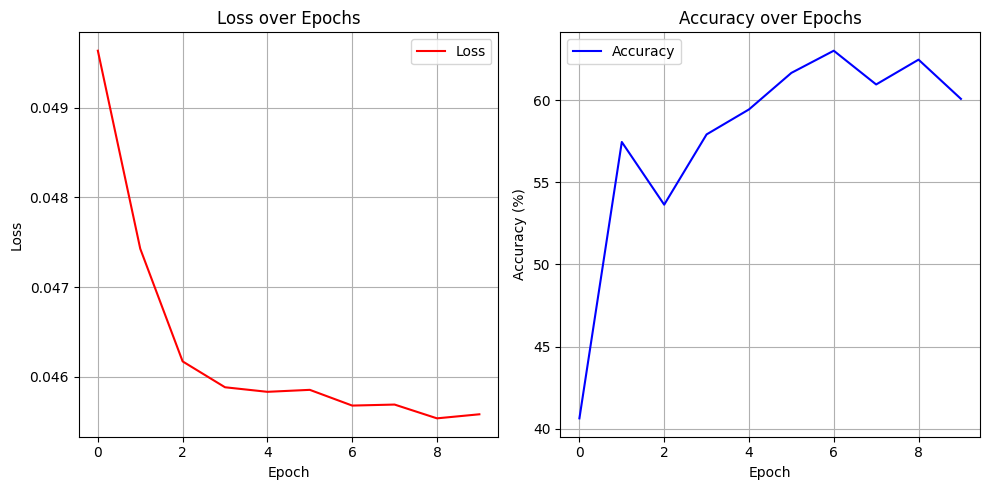

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Separate lists for loss and accuracy
losses = []
accuracies = []

# Parse the data
for entry in Losses:
    loss_str, acc_str = entry.split(',')

    # Convert loss to float and remove % from accuracy, converting to float
    losses.append(float(loss_str))
    accuracies.append(float(acc_str.strip('%')))

def divide_list(lst, n):
    # Use list comprehension to divide the list into n parts
    return [lst[i * len(lst) // n : (i + 1) * len(lst) // n] for i in range(n)]

# Divide the list into 10 parts
divided_lists_losses = divide_list(losses, 10)
divided_lists_acc = divide_list(accuracies, 10)

means_l = [np.mean(sublist) for sublist in divided_lists_losses]
means_cc = [np.mean(sublist) for sublist in divided_lists_acc]

# Plotting
plt.figure(figsize=(10,5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(means_l, label='Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(means_cc, label='Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


### Prédiction

In [ ]:
import trimesh
import numpy as np
def one_file_preprocessing(file_path, resolution=30):

    mesh = trimesh.load(file_path)  # Load the 3D mesh from the file using trimesh.
    points, _ = trimesh.sample.sample_surface(mesh, count=10000)  # Sample 10,000 points from the surface of the mesh.

    # Avoid division by zero by checking if max == min
    diff = points.max(axis=0) - points.min(axis=0)
    diff[diff == 0] = 1  # Avoid division by zero

    points_normalized = (points - points.min(axis=0)) / diff # Normalize the points to fit within a unit cube [0, 1].
    points_voxels = (points_normalized * (resolution - 1)).astype(int)  # Scale the normalized points to the voxel grid resolution and convert them to integers.

    grid = np.zeros((resolution, resolution, resolution), dtype=bool)  # Initialize a 3D voxel grid with the given resolution.
    grid[points_voxels[:, 0], points_voxels[:, 1], points_voxels[:, 2]] = True  # Mark the grid cells corresponding to the sampled points as occupied (True).

    voxel_grid = grid.astype(np.float32)  # Convert the voxel grid to float32 for further processing.

    voxel_grid_tensor = tf.convert_to_tensor(voxel_grid, dtype=tf.float32)  # Convert the voxel grid to a TensorFlow tensor.
    voxel_grid_tensor = tf.expand_dims(voxel_grid_tensor, axis=-1)  # Add a channel dimension to the tensor (for Conv3D compatibility).

    return voxel_grid_tensor  # Return the processed voxel grid tensor.
capsule_net.predict(one_file_preprocessing(r"ModelNet40\bathtub\train\bathtub_0018.off"))


array([5], dtype=int64)